In [325]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [326]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [327]:
!pip install pycaret

In [328]:
#import modules
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
%matplotlib inline

In [329]:
KAGGLE=False

In [330]:
if KAGGLE:
    path='../input/jobathonfebruary2022/'
else:
    path=''

In [331]:
train = pd.read_csv(path+'train_0OECtn8.csv')
test = pd.read_csv(path+'test_1zqHu22.csv')
subm = pd.read_csv(path+'sample_submission_JPlpRcN.csv')

In [332]:
print(train.shape)
print(test.shape)

(89197, 10)
(11121, 9)


In [333]:
def preproc(train,test):
    label_encoder = LabelEncoder()

    train['gender']= label_encoder.fit_transform(train['gender'])
    test['gender']= label_encoder.transform(test['gender'])
    
    #ordinal encoding of profession
    prof_map = {'Other':0,'Student':1,'Working Professional':2}
    train['profession'] = train['profession'].map(prof_map)
    test['profession'] = test['profession'].map(prof_map)

def gen_agg(train,test):
    #user_id aggregate features
    user_agg = train[['user_id','video_id','category_id']].groupby('user_id').agg('nunique').reset_index()
    user_agg = user_agg.rename({'video_id':'user_video_count','category_id':'user_category_count'},axis=1)
    train = pd.merge(train, user_agg, how='left', on='user_id')
    test = pd.merge(test, user_agg, how='left', on='user_id')
    
    
    #category_id aggregate features
    cat_agg = train[['category_id','user_id','video_id','age','gender','profession']] \
                        .groupby('category_id') \
                        .agg({'user_id':'nunique','video_id':'nunique', \
                             'age':'mean','gender':'mean','profession':'mean'}) \
                        .reset_index()
    cat_agg = cat_agg.rename({'user_id':'category_user_count',
                              'video_id':'category_video_count',
                              'age':'category_age_mean',
                              'gender':'category_gender_mean',
                              'profession':'category_profession_mean',
                             }, axis=1)
    train = pd.merge(train, cat_agg, how='left', on='category_id')
    test = pd.merge(test, cat_agg, how='left', on='category_id')    
    
    #video_id aggregate features
    video_agg = train[['video_id','age','gender','profession']] \
                        .groupby('video_id') \
                        .agg('mean') \
                        .reset_index() 
    video_agg = video_agg.rename({'age':'video_age_mean',
                              'gender':'video_gender_mean',
                              'profession':'video_profession_mean',
                             },axis=1)
    train = pd.merge(train, video_agg, how='left', on='video_id')
    test = pd.merge(test, video_agg, how='left', on='video_id')    

    return train,test
        

In [334]:
preproc(train,test)

In [335]:
train,test = gen_agg(train,test)

In [336]:
print(train.columns)
train.head()

Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'gender',
       'profession', 'followers', 'views', 'engagement_score',
       'user_video_count', 'user_category_count', 'category_user_count',
       'category_video_count', 'category_age_mean', 'category_gender_mean',
       'category_profession_mean', 'video_age_mean', 'video_gender_mean',
       'video_profession_mean'],
      dtype='object')


,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score,user_video_count,user_category_count,category_user_count,category_video_count,category_age_mean,category_gender_mean,category_profession_mean,video_age_mean,video_gender_mean,video_profession_mean
0,1,19990,37,128,24,1,1,180,1000,4.33,3,2,635,2,24.816008,0.602911,0.922037,24.864811,0.602386,0.912525
1,2,5304,32,132,14,0,1,330,714,1.79,5,3,1507,4,24.884218,0.563053,0.862832,25.104735,0.569584,0.892396
2,3,1840,12,24,19,1,1,180,138,4.35,3,1,2020,6,24.836205,0.670352,0.883775,25.039640,0.681081,0.935135
3,4,12597,23,112,19,1,1,220,613,3.77,3,2,1705,2,25.175964,0.642456,0.897791,25.248317,0.641735,0.893044
4,5,13626,23,112,27,1,2,220,613,3.13,4,2,1705,2,25.175964,0.642456,0.897791,25.248317,0.641735,0.893044


In [337]:
targetcol = 'engagement_score'
target = train[targetcol]

In [338]:
exclude_cols =['row_id', 'category_age_mean', 'category_gender_mean',
       'category_profession_mean',  'video_gender_mean',
       'video_profession_mean']
features =[col for col in train.columns if col not in exclude_cols]
print(len(features))
print(features)
features_excl_target = [col for col in features if col!=targetcol]

14
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'engagement_score', 'user_video_count', 'user_category_count', 'category_user_count', 'category_video_count', 'video_age_mean']


In [339]:
catcols = ['gender']
numeric_cols = [col for col in features if col not in catcols+[targetcol]]
print(numeric_cols)

['user_id', 'category_id', 'video_id', 'age', 'profession', 'followers', 'views', 'user_video_count', 'user_category_count', 'category_user_count', 'category_video_count', 'video_age_mean']


In [340]:
from pycaret.regression import *

In [341]:
preprocessor = ('Target encoding', TargetEncoder(cols=['user_id','category_id', 'video_id'],
                                                min_samples_leaf=2, smoothing=0.1) )

In [342]:
# ce_target=TargetEncoder(cols=['user_id','category_id', 'video_id'],
#                        min_samples_leaf=2, smoothing=0.1)
# ce_target.fit(train,target)

# ret =ce_target.transform(train,target)
# ret.head()

In [343]:
s = setup(train[features], session_id=100,
          silent=True,
          numeric_features=numeric_cols,
          categorical_features=catcols,
          target = targetcol,
          custom_pipeline=preprocessor,
          fold=10,fold_shuffle=False,
          )

,Description,Value
0,session_id,100
1,Target,engagement_score
2,Original Data,"(89197, 14)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(62437, 13)"


In [344]:
%%time
lgbm = create_model('lightgbm')
lgbm

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5012,0.4667,0.6831,0.4014,0.1922,0.2424
1,0.5023,0.4547,0.6743,0.3836,0.1825,0.2422
2,0.5105,0.4793,0.6923,0.3783,0.1912,0.2807
3,0.5025,0.4571,0.6761,0.3810,0.1845,0.2255
4,0.5034,0.4640,0.6811,0.3881,0.1875,0.1965
5,0.5101,0.4736,0.6882,0.3648,0.1863,0.2258
6,0.4970,0.4450,0.6671,0.3906,0.1789,0.1911
7,0.5037,0.4624,0.6800,0.3855,0.1861,0.2342
8,0.4943,0.4418,0.6647,0.3896,0.1791,0.2388
9,0.5034,0.4606,0.6787,0.3906,0.1877,0.2595


CPU times: user 2.84 s, sys: 19.1 ms, total: 2.86 s
Wall time: 2.46 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

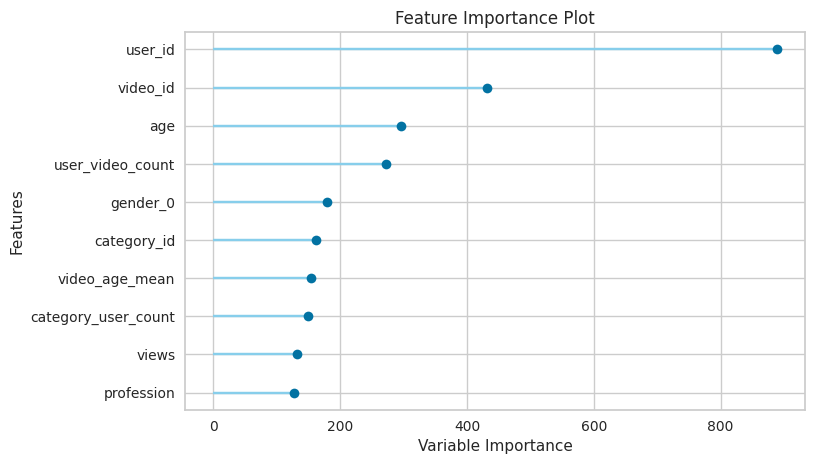

In [345]:
plot_model(lgbm,'feature')

In [346]:
%%time
#test predictions
final_model = finalize_model(lgbm)
test_preds = predict_model(final_model, data=test)
print(test_preds.head())

   row_id  user_id  category_id  video_id  age  gender  profession  followers  \
0   89198     7986           12        42   14       1           1        180   
1   89199    11278           34       115   14       1           1        230   
2   89200    17245            8       110   44       0           2        280   
3   89201     9851           16       137   18       1           1        270   
4   89202    16008           34        96   47       0           0        230   

   views  user_video_count  user_category_count  category_user_count  \
0    138                 2                    1                 2020   
1    840                 5                    3                 1679   
2    628                 5                    2                 3043   
3    462                 3                    2                 1670   
4    840                 3                    2                 1679   

   category_video_count  category_age_mean  category_gender_mean  \
0           

In [347]:
%%time
#train predictions
train_preds = predict_model(final_model, data=train)
print(train_preds.head())
print('full train score:',r2_score(target,train_preds['Label']))

   row_id  user_id  category_id  video_id  age  gender  profession  followers  \
0       1    19990           37       128   24       1           1        180   
1       2     5304           32       132   14       0           1        330   
2       3     1840           12        24   19       1           1        180   
3       4    12597           23       112   19       1           1        220   
4       5    13626           23       112   27       1           2        220   

   views  engagement_score  ...  user_category_count  category_user_count  \
0   1000              4.33  ...                    2                  635   
1    714              1.79  ...                    3                 1507   
2    138              4.35  ...                    1                 2020   
3    613              3.77  ...                    2                 1705   
4    613              3.13  ...                    2                 1705   

   category_video_count  category_age_mean  catego

In [348]:
lgbm

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

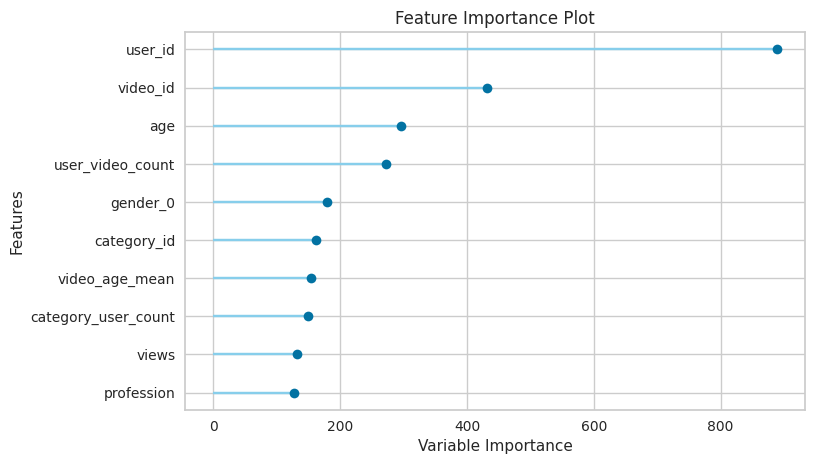

In [349]:
plot_model(lgbm,'feature')

In [350]:
submission = test_preds[['row_id','Label']]
submission=submission.rename(columns={'Label':'engagement_score'})
submission[['row_id','engagement_score']].to_csv('submission.csv',index=False)

In [351]:
test_sub = pd.read_csv('submission.csv')

In [352]:
print(test_sub.shape)
test_sub.head()

(11121, 2)


,row_id,engagement_score
0,89198,4.187767
1,89199,4.030052
2,89200,2.290532
3,89201,2.871033
4,89202,2.293723
